# Train, Inference, Evaluate (WIP)

## Creating our working directory

For our experiments, we'll use the following folder to save the model, training artifacts, and our working configs.

In [2]:
from pathlib import Path

tutorial_dir = "vision_language_tutorial"

Path(tutorial_dir).mkdir(parents=True, exist_ok=True)

In [3]:
model_name = "Qwen/Qwen2-VL-2B-Instruct"

In [4]:
from oumi.builders import build_tokenizer
from oumi.core.configs import ModelParams
from oumi.datasets.vision_language.vqav2_small import Vqav2SmallDataset

# Initialize the dataset
tokenizer = build_tokenizer(ModelParams(model_name=model_name))
dataset = Vqav2SmallDataset(
    tokenizer=tokenizer,
    processor_name=model_name,
    limit=1000,  # Limit the number of examples to load for demonstration purposes
)

[2025-01-22 17:04:39,905][oumi][rank0][pid:97845][MainThread][INFO]][models.py:422] Using the chat template 'qwen2-vl-instruct', which is the default for model 'Qwen/Qwen2-VL-2B-Instruct'.
[2025-01-22 17:04:39,907][oumi][rank0][pid:97845][MainThread][INFO]][base_map_dataset.py:68] Creating map dataset (type: Vqav2SmallDataset) dataset_name: 'None', dataset_path: 'None'...
[2025-01-22 17:04:42,067][oumi][rank0][pid:97845][MainThread][INFO]][base_map_dataset.py:472] Dataset Info:
	Split: validation
	Version: 0.0.0
	Dataset size: 3391008667
	Download size: 3376516283
	Size: 6767524950 bytes
	Rows: 21435
	Columns: ['multiple_choice_answer', 'question', 'image']
[2025-01-22 17:04:48,138][oumi][rank0][pid:97845][MainThread][INFO]][base_map_dataset.py:411] Loaded DataFrame with shape: (21435, 3). Columns:
multiple_choice_answer    object
question                  object
image                     object
dtype: object


In [5]:
dataset.data.head()  # Display the first few rows of the dataset

,multiple_choice_answer,question,image
0,carnival ride,Where are the kids riding?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,yes,Is this boy a good pitcher?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,wetsuit,What is the person wearing?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,4,How many sinks are in this bathroom?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,soccer,What sport are the girls playing?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


Example 1:


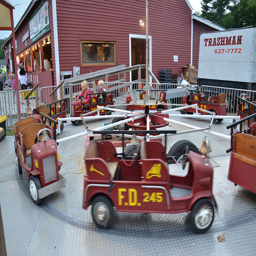

user: [<IMAGE_BINARY>, Where are the kids riding?]...
assistant: carnival ride...


Example 2:


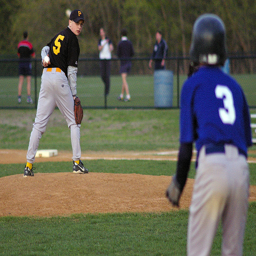

user: [<IMAGE_BINARY>, Is this boy a good pitcher?]...
assistant: yes...




In [8]:
import io

from PIL import Image

from oumi.core.types.conversation import Type

# Print a few examples
for i in range(2):
    conversation = dataset.conversation(i)
    print(f"Example {i + 1}:")
    for message in conversation.messages:
        ## More pythonic way to display image below???
        if message.role == "user":  # User poses a question, regarding an image
            img_content = message.content[0]
            assert img_content.type == Type.IMAGE_BINARY
            image = Image.open(io.BytesIO(img_content.binary))
            display(image.resize((256, 256)))  # Resize for display

        print(f"{message.role}: {message.content[:100]}...")  # Truncate for brevity
    print("\n")